# Uncertainty 

This is a tutorial for the uncertainty module.

## Uncertainty and sensitivity analysis?

Before doing an uncertainty analysis in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g. [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel2020](https://www.research-collection.ethz.ch/handle/20.500.11850/399735).

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="600">

1. [Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
2. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
3. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
4. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Uncertainty Module Structure

The uncertainty module contains 2 main classes
- `UncVar`: defines uncertainty variables
- `Uncertainty`: base class to compute uncertainties and sensitivities for CLIMADA outputs.

In addition, there are the child classes of `Uncertainty` defined in their submodules:

- `UncImpact`: specific class to compute uncertainties for outputs of `climada.engine.impact.calc`
- `UncCostBenefit`: specific class to compute uncertainties for outputs of `climada.engine.cost_benefit.calc`

## UncVar 

The UncVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| uncvar_func | funnction | Variable defined as a function of the uncertainty parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty parameters |

An **uncertainty parameter** is an input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope the vulnerability function, the exponent of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the uncertainty parameters (keyword arguments of the `uncvar_func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

### Example - continuous uncertainty parameter

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [1]:
#Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

2021-06-22 15:40:30,188 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5


In [2]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the uncertainty parameter and exp_func the uncvar_func.
def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp

In [3]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the uncertainty parameter x_exp is sp.stats.uniform(0.9, 1.1)
from climada.engine.uncertainty import UncVar
import scipy as sp

exp_distr = {"x_exp": sp.stats.uniform(0.9, 1.1),
              }
exp_unc = UncVar(exp_func, exp_distr)

In [4]:
# Uncertainty parameters
exp_unc.labels

['x_exp']

In [5]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_unc.uncvar_func(x_exp = 0.95)
print(f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}")

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


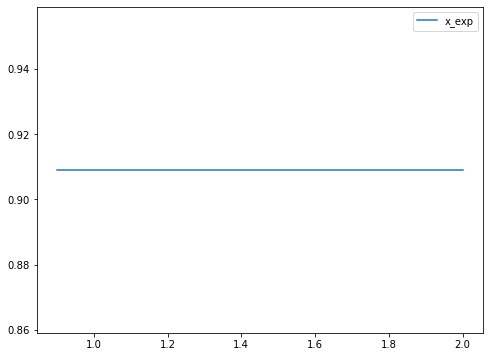

In [6]:
# Defined distribution
exp_unc.plot(figsize=(8, 6));

### Example - categorical uncertainty parameter 

Suppose we want to test different exponents (m=0,1,2 ; n=0,1,2) for the LitPop exposure for the country Switzerland.

In [7]:
from climada.entity import LitPop

m_min, m_max = (0, 2)
n_min, n_max = (0, 2)

# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow. 
def litpop_cat(m, n):
    exp = Litpop()
    exp.set_country('CHE', exponent=[m, n])
    return exp

In [8]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time (here ~3-4mins)
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = exp.copy()
        exp_mn.set_country('CHE', exponents=[m, n])
        litpop_dict[(m, n)] = exp_mn
        
def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

2021-06-22 15:40:31,912 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-06-22 15:40:40,885 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GPW population data: 2015
2021-06-22 15:40:40,886 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-06-22 15:40:55,278 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-06-22 15:40:55,717 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-06-22 15:40:56,425 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-06-22 15:40:56,426 - climada.entity.exposures.base - INFO - category_id not set.
2021-06-22 15:40:56,427 - climada.entity.exposures.base - INFO - cover not set.
2021-06-22 15:40:56,427 - climada.entity.exposures.base - INFO - deductible not set.
2021-06-22 15:40:56,427 - climada.entity.exposures.base - INFO - geometry not set.
2021-06-22 15:40:56,428 - climada.entity.exposu

2021-06-22 15:42:51,768 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-06-22 15:42:51,768 - climada.entity.exposures.base - INFO - category_id not set.
2021-06-22 15:42:51,769 - climada.entity.exposures.base - INFO - cover not set.
2021-06-22 15:42:51,770 - climada.entity.exposures.base - INFO - deductible not set.
2021-06-22 15:42:51,770 - climada.entity.exposures.base - INFO - geometry not set.
2021-06-22 15:42:51,771 - climada.entity.exposures.base - INFO - centr_ not set.
2021-06-22 15:42:51,782 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-06-22 15:42:51,783 - climada.entity.exposures.base - INFO - category_id not set.
2021-06-22 15:42:51,783 - climada.entity.exposures.base - INFO - cover not set.
2021-06-22 15:42:51,784 - climada.entity.exposures.base - INFO - deductible not set.
2021-06-22 15:42:51,784 - climada.entity.exposures.base - INFO - geometry not set.
2021-06-22 15:42:51,785 - climada.entity.exposures.base - INFO 

In [9]:
#Define the distribution dictionnary
import scipy as sp
from climada.engine.uncertainty import UncVar

distr_dict = {
    'm': sp.stats.randint(low=m_min, high=m_max),
    'n': sp.stats.randint(low=n_min, high=n_max)
    }

unc_var_cat = UncVar(litpop_cat, distr_dict) # One can use either of the above definitions of litpop_cat

In [10]:
# Uncertainty parameters
unc_var_cat.labels

['m', 'n']

##  UncImpact

### Set the UncVars 

import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.entity.entity_def import Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In this example, we model the impact function for tropical cyclones on the parametric function suggested in Emanuel (2015) with 4 parameters. The exposures total value varies between 80% and 120%. For that hazard, we assume to have no good error estimate and thus do not define an UncVar for the hazard.

In [1]:
#Define the uncvar_funcs
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Hazard

def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

haz = Hazard()
haz.read_hdf5(HAZ_DEMO_H5)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)
#It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz) 

def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    exp.check()
    return exp


2021-06-22 15:46:03,216 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2021-06-22 15:46:03,247 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-06-22 15:46:03,311 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-06-22 15:46:03,330 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<AxesSubplot:title={'center':'TC 1: '}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

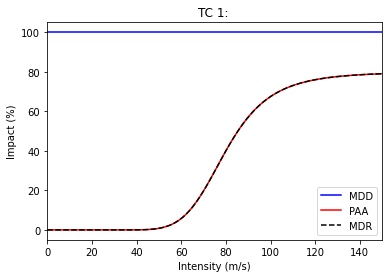

In [2]:
# Visualization of the parametrized impact function
impf_func(G=0.8, v_half=80, vmin=30,k=5).plot()

In [3]:
#Define the UncVars

import scipy as sp
from climada.engine.uncertainty import UncVar

exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf_func, impf_distr)

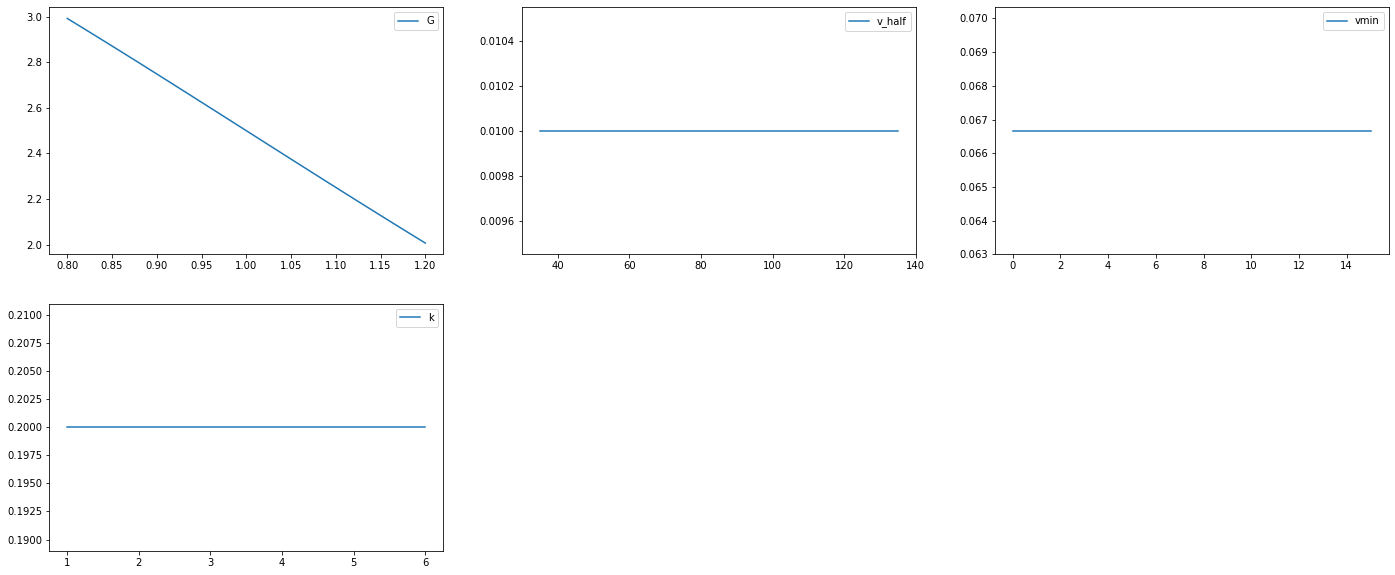

In [4]:
impf_unc.plot();

### Compute uncertainty and sensitivity using default methods 

First, we define the UncImpact object with our uncertainty variables. 

In [5]:
from climada.engine.uncertainty import UncImpact

unc = UncImpact(exp_unc, impf_unc, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [6]:
unc.make_sample(N=100)

2021-06-22 15:46:04,900 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1200


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
1195,0.600502,1.015208,41.396484,11.037598,4.239746
1196,0.600502,0.853179,91.494141,11.037598,4.239746
1197,0.600502,0.853179,41.396484,1.560059,4.239746
1198,0.600502,0.853179,41.396484,11.037598,5.855957


The resulting samples can be visualized in plots.

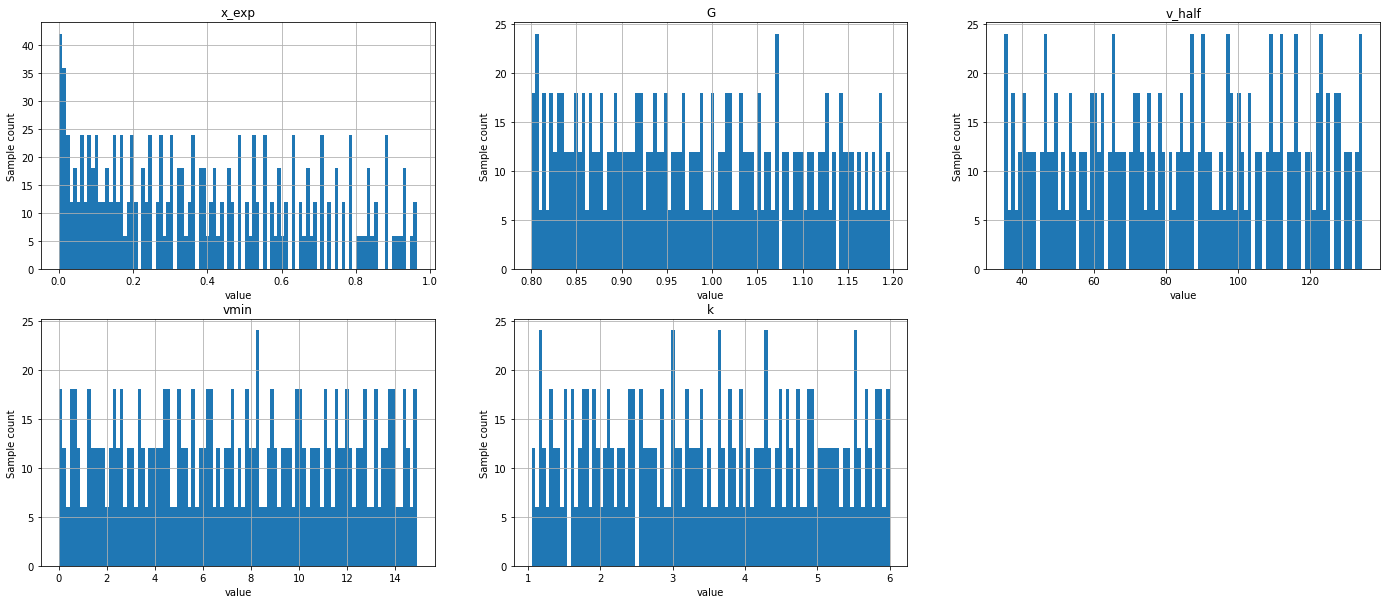

In [7]:
unc.plot_sample();

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to restrict the return periods 50, 100, and 250 years. By default, `eai_exp` and `at_event` are not stored.

In [8]:
unc.calc_distribution(rp = [50, 100, 250])

2021-06-22 15:46:06,028 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:06,030 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:06,032 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:06,037 - climada.engine.uncertainty.base - INFO - Estimated computaion time: 19 days, 7:40:48
2021-06-22 15:46:06,037 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 19.32 s



The distributions of metrics ouputs are stored as dictionaries of pandas dataframe. The metrics are directly taken from the output of `climada.impact.calc`. 

In [9]:
unc.metric_names

['aai_agg', 'freq_curve', 'eai_exp', 'at_event', 'tot_value']

In [10]:
unc.metrics

{'aai_agg':            aai_agg
 0     1.452259e+08
 1     9.638108e+08
 2     1.422086e+08
 3     5.798529e+07
 4     1.699837e+08
 ...            ...
 1195  3.466737e+09
 1196  8.223227e+07
 1197  3.519707e+09
 1198  2.475507e+09
 1199  2.913440e+09
 
 [1200 rows x 1 columns],
 'freq_curve':               rp50         rp100         rp250
 0     4.190439e+09  5.459388e+09  6.716189e+09
 1     2.781041e+10  3.623196e+10  4.457288e+10
 2     4.103377e+09  5.345963e+09  6.576651e+09
 3     1.668605e+09  2.195785e+09  2.728832e+09
 4     4.852968e+09  6.169638e+09  7.454678e+09
 ...            ...           ...           ...
 1195  1.027197e+11  1.440714e+11  1.832228e+11
 1196  2.242984e+09  3.585708e+09  5.083031e+09
 1197  1.027906e+11  1.314927e+11  1.574598e+11
 1198  7.067343e+10  1.096797e+11  1.503698e+11
 1199  8.632543e+10  1.210773e+11  1.539801e+11
 
 [1200 rows x 3 columns],
 'eai_exp': Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

The distributions of the one-dimensioanl metrics (`eai_exp` and `at_event` are not shown) can be vizualised with plots.

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/

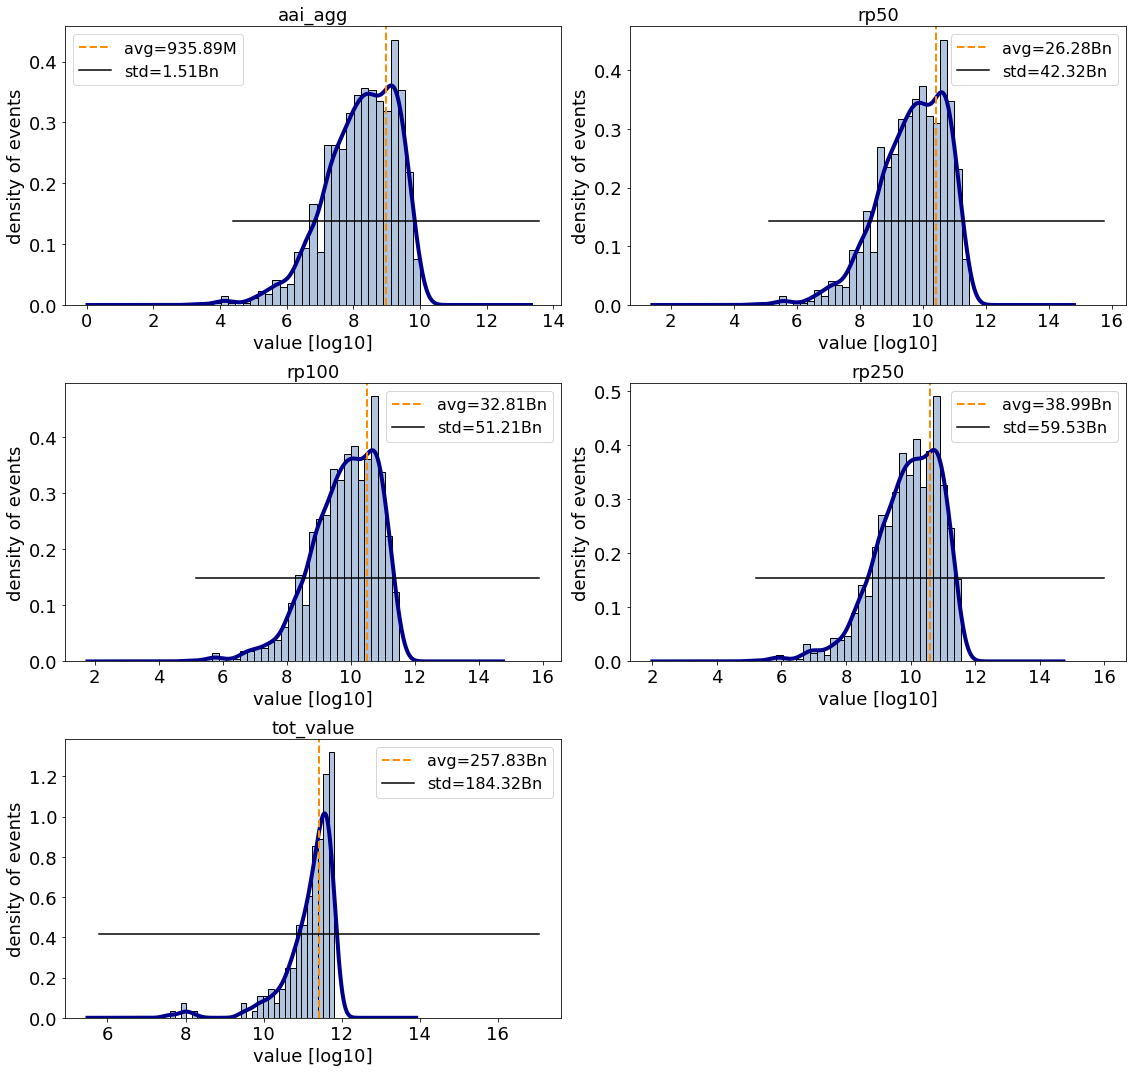

In [11]:
unc.plot_distribution(log=True);

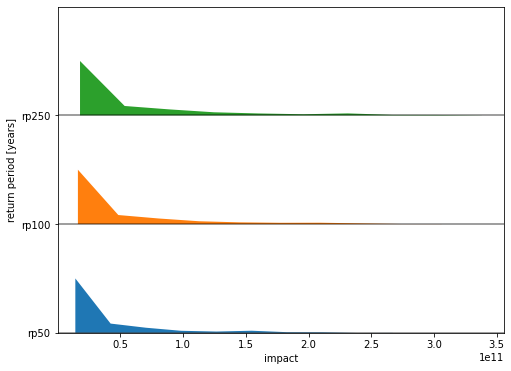

In [12]:
# Specific plot for the return period distributions
unc.plot_rp_distribution();

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

The sensitivity indices dictionnaries outputs from the SAlib methods are stored in the same structure of nested dictionnaries as the metrics distributions. Note that depending on the chosen sensitivity analysis method the returned indices dictionnary will return specific types of sensitivity indices with specific names. Please get familiar with [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

Note that in our case, several of the second order sensitivity indices are negative. For the default method `sobol`, this indicates that the algorithm has not converged and cannot give realiable values for these sensitivity indices. If this happens, please use a larger number of samples. Here we will focus on the first-order indices.

In [13]:
unc.calc_sensitivity()

{'aai_agg': {'aai_agg': {'S1': array([0.35319533, 0.02894084, 0.29014581, 0.00245273, 0.07358847]),
   'S1_conf': array([0.1630911 , 0.0419846 , 0.20729112, 0.02402006, 0.12377323]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.20400516, 0.01720829, 0.34263589, 0.00838979, 0.13560513]),
   'S2': array([[        nan, -0.24100036, -0.0349894 , -0.24132635, -0.169576  ],
          [        nan,         nan, -0.05162803, -0.04726681, -0.04375917],
          [        nan,         nan,         nan, -0.02073784,  0.00665134],
          [        nan,         nan,         nan,         nan, -0.00056325],
          [        nan,         nan,         nan,         nan,         nan]]),
   'S2_conf': array([[       nan, 0.21715556, 0.48460872, 0.21663833, 0.24326976],
          [       nan,        nan, 0.08122033, 0.07562424, 0.05372875],
          [       nan,        nan,        nan, 0.27596982, 0.31877169],
          [       nan,        nan,  

The value of the sensitivity indices can be plotted for each metric that is one-dimensional (`eai_exp` and `at_event` are not shown in this plot). 

As expected, the `tot_value` of the exposure is only dependent on the exposure parameter `x_exp`. We further see that both the errors in `freq_curve` and in `aai_agg` are mostly determined by `x_exp` and `v_half`. Finally, we see small differences in the sensitivity of the different return periods.

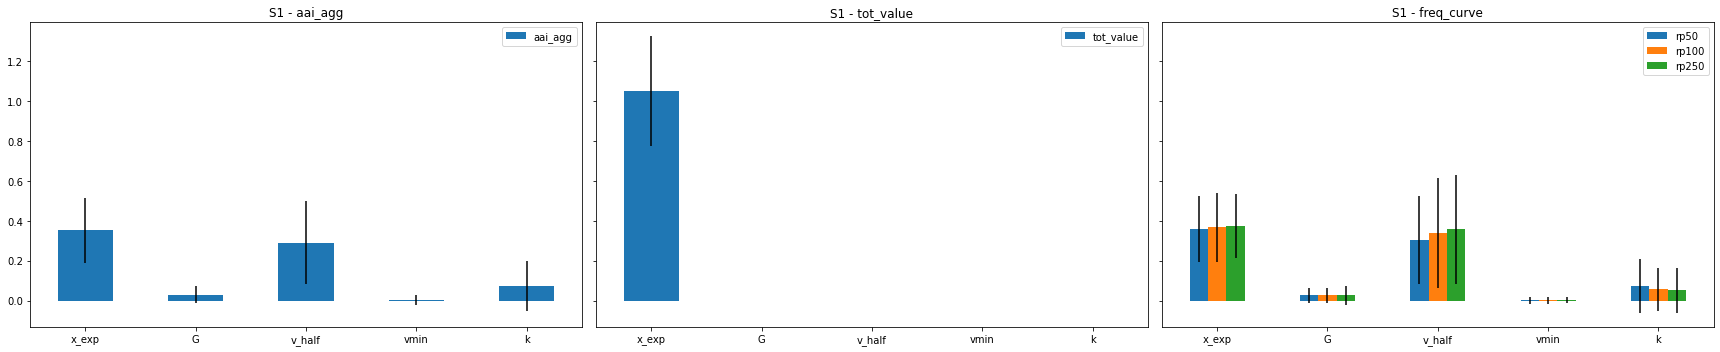

In [14]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
unc.plot_sensitivity();

Note that since we have quite a few measures, the imp_meas_fut and imp_meas_pres plots are too crowded. We can select only the other metrics easily. In addition, instead of showing first order sensitivity 'S1', we can plot the total sensitivity 'ST'.

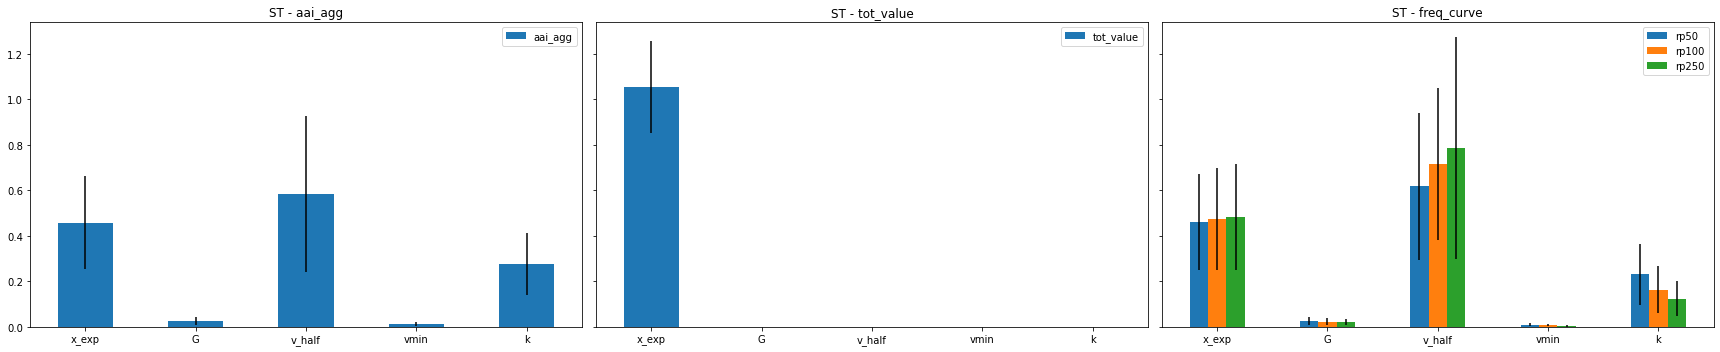

In [15]:
unc.plot_sensitivity(salib_si = 'ST');

One can also vizualise the second-order sensitivity indices in the form of a correlation matrix.

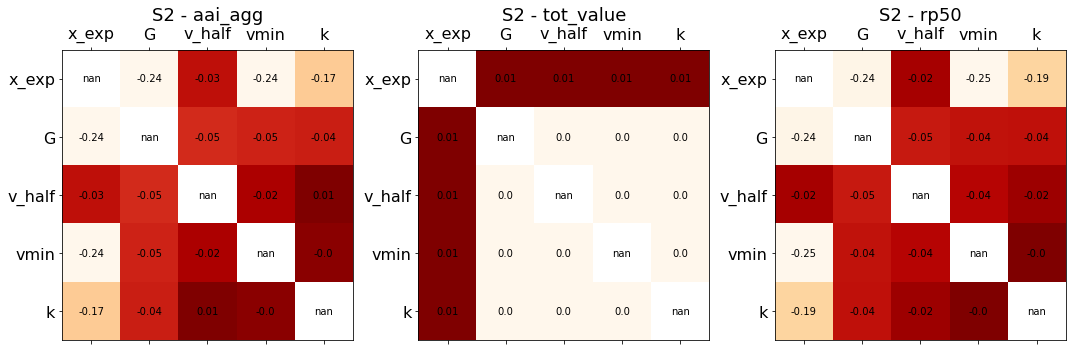

In [16]:
unc.plot_sensitivity2d();

### A few non-default parameters

We shall use the same uncertainty variables as in the previous section but show a few possibilities to use non-default method arguments.

In [17]:
# Sampling method "latin" hypercube instead of `saltelli`.
from climada.engine.uncertainty import UncImpact

unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=1000, sampling_method='latin')

2021-06-22 15:46:29,757 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1000


,x_exp,G,v_half,vmin,k
0,0.575939,1.160807,88.611929,0.109686,2.168492
1,0.897724,1.105219,74.089033,12.836009,3.933925
2,0.010998,1.066954,73.462392,3.730362,5.079883
3,0.815042,0.820703,58.613659,7.308026,5.110619
4,0.446449,0.800633,81.925560,14.838962,1.103314
...,...,...,...,...,...
995,0.258288,0.885149,60.917433,4.337172,4.147099
996,0.266156,0.935325,53.082930,5.606197,1.993047
997,0.847053,0.917058,134.302105,10.506858,3.021011
998,0.350467,0.944037,94.818431,3.095525,4.608669


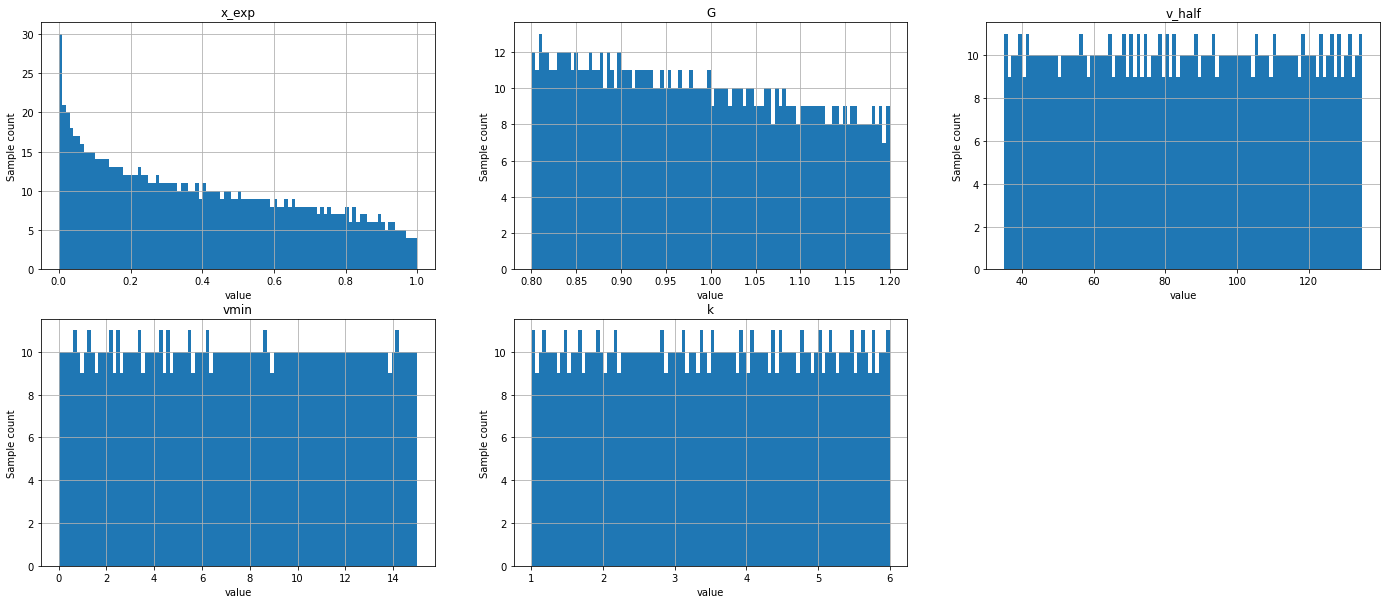

In [18]:
unc.plot_sample();

In [19]:
# Compute also the distribution of the metric `eai_exp`
# To speed-up the comutations, we use a ProcessPool for parallel computations
from pathos.pools import ProcessPool as Pool
pool = Pool()
unc.calc_distribution(rp = [50, 100, 250], calc_eai_exp=True, pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-06-22 15:46:31,215 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,217 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,219 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,224 - climada.engine.uncertainty.base - INFO - Estimated computaion time: 2 days, 17:24:00
2021-06-22 15:46:31,225 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 2.73 s



/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,379 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,385 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,389 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,402 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,403 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,404 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,406 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,408 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,411 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,431 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,431 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,433 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,434 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,436 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,464 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,465 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,469 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,469 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,469 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,471 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,474 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,474 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,494 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,510 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,515 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,517 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,521 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,529 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,531 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Con

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,565 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,568 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,572 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,573 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,577 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,581 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,582 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:3

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:31,612 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,608 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,612 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,619 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,621 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,622 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,621 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:3

2021-06-22 15:46:31,720 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,723 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,725 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,728 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,732 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,732 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:31,825 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,822 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,829 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,829 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,832 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,832 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,836 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:31,886 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,917 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,922 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:31,923 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:31,925 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:31,927 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-2

2021-06-22 15:46:32,011 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,012 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,013 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,015 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,015 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,015 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,009 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:32,095 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,081 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,102 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,106 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,106 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,110 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,110 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Con

2021-06-22 15:46:32,198 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,201 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,201 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,205 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,205 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,208 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,211 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,199 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,213 - c

2021-06-22 15:46:32,287 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,287 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,291 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,308 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,311 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,312 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,315 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 

2021-06-22 15:46:32,404 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,407 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,407 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,406 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,410 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,410 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,411 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:32,482 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,483 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,485 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,486 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,489 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,492 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,493 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 

2021-06-22 15:46:32,576 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,579 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,574 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,577 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,580 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,580 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa 

2021-06-22 15:46:32,666 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,671 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,673 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,675 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,675 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,675 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,693 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,697 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,697 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,700 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,702 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,701 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,727 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,730 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,731 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,735 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,736 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,739 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,740 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,767 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,767 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,770 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,770 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,773 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,776 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,781 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,812 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,813 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,817 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,817 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,823 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,846 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,849 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,834 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,849 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,849 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,896 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,899 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,902 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,903 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,903 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,907 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. C

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,981 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,982 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,983 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,985 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,986 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,988 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,989 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:3

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:32,993 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,994 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:32,994 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,997 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:32,998 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:32,998 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,001 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 

2021-06-22 15:46:33,114 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,101 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,115 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,117 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,119 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,118 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,121 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,123 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,123 - c

2021-06-22 15:46:33,218 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,221 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,222 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,221 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,224 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,225 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-2

2021-06-22 15:46:33,332 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,331 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,334 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,335 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,336 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,334 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,339 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 

2021-06-22 15:46:33,419 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,382 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,412 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,420 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,417 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,425 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,435 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 

2021-06-22 15:46:33,511 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,511 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,515 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,516 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,515 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,516 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,519 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,522 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,

2021-06-22 15:46:33,606 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,609 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,612 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,601 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,619 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,622 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,624 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 

2021-06-22 15:46:33,714 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,721 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,725 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,719 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,726 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,705 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,729 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:3

2021-06-22 15:46:33,817 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,818 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,820 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,820 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,823 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,823 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,828 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,830 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consi

2021-06-22 15:46:33,919 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,921 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,920 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,922 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:33,924 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:33,925 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:33,922 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:3

2021-06-22 15:46:34,002 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,005 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,009 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,005 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,015 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,015 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2021-06-22 15:46:34,129 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,131 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,134 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,136 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,137 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,142 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,147 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,148 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,151 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,151 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,157 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,157 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,158 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,163 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,193 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,194 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,195 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,196 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,197 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,197 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,233 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,234 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,236 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,237 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,238 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,240 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,279 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,279 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,282 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,281 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,281 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,284 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,320 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,321 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,323 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,327 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,327 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,327 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,331 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,412 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,410 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,415 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,413 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,416 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,417 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,420 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:34,497 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,498 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,504 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,501 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,502 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,510 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,510 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:34,606 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,611 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,607 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,614 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,615 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,615 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2021-06-22 15:46:34,710 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,713 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,717 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,720 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,713 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,722 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,722 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:34,814 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,816 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,819 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,820 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,820 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,820 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-2

2021-06-22 15:46:34,903 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,904 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,904 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,905 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,905 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:34,908 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46

2021-06-22 15:46:34,978 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,980 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,980 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:34,977 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,982 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,983 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,987 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:34,999 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15

2021-06-22 15:46:35,068 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,068 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,070 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,071 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,078 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,081 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,085 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-06-22 15:46:35,146 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,177 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,173 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,177 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,181 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


2021-06-22 15:46:35,285 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,286 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,288 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,291 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,290 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,295 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,296 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,297 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,

2021-06-22 15:46:35,388 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,389 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,390 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,392 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,399 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,403 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,387 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,408 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shi

2021-06-22 15:46:35,491 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,492 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,493 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,494 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,498 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,497 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,499 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,501 - c

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,512 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,514 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,520 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,521 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,522 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,524 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,591 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,596 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,597 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,600 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,604 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,608 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,604 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,631 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,631 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,636 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,639 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,640 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,641 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,670 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,670 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,673 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,673 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,678 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,680 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-2

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,712 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,715 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,716 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,716 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,716 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,718 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,721 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:3

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,769 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,769 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,769 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,771 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,772 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,773 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,774 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:3

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:35,900 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,906 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,908 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,911 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:35,911 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:35,918 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:35,923 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:3

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:46:36,045 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,051 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,048 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,058 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,057 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,063 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,055 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:36,169 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,178 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,178 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,187 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,189 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,197 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,198 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:36,294 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,296 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,296 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,296 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,297 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,297 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-2

2021-06-22 15:46:36,396 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,396 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,397 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,403 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,398 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,400 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,403 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-06-22 15:46:36,493 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,496 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,492 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,500 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,499 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,500 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

2021-06-22 15:46:36,592 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,594 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,600 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,603 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,603 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,604 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,604 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 

2021-06-22 15:46:36,698 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,700 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,702 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,706 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,703 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2021-06-22 15:46:36,797 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,798 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,801 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,803 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,808 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,812 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,812 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-06-22 15:46:36,904 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,908 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:36,907 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,911 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:36,915 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:36,917 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-2

2021-06-22 15:46:37,031 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:37,032 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:37,032 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:37,033 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:46:37,034 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-22 15:46:37,037 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:37,038 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:46:3

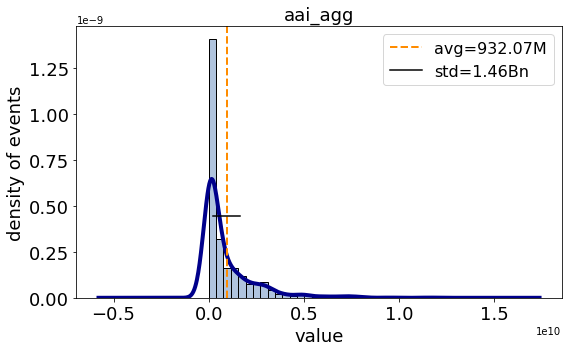

In [20]:
# plot the aai_agg distribution only
unc.plot_distribution(metric_list=['aai_agg']);

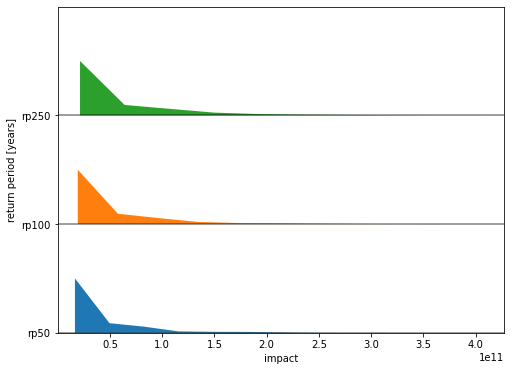

In [21]:
unc.plot_rp_distribution();

In [22]:
# Use the method 'rbd_fast' which is recommend in pair with 'latin'. In addition, change one of the kwargs 
# (M=15) of the salib sampling method.
unc.calc_sensitivity(salib_method='rbd_fast', method_kwargs = {'M': 15})

{'aai_agg': {'aai_agg': {'S1': [0.20013301035484587,
    -0.001501246106909323,
    0.30287505772761,
    0.0158414306245571,
    0.16539535490434293],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'freq_curve': {'rp50': {'S1': [0.20290962541682106,
    -0.0007843533084333117,
    0.32503910589018,
    0.015266256921144285,
    0.14340006843878356],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp100': {'S1': [0.22114338288534735,
    0.0014132622239020273,
    0.3596927182947634,
    0.015186238361248706,
    0.10215903230304174],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp250': {'S1': [0.2354693940731751,
    0.003276926545820208,
    0.3790162395690592,
    0.015293960735904132,
    0.07399951072500056],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'eai_exp': {0: {'S1': [0.21292101304485558,
    -0.0006234020976582065,
    0.31844034389543796,
    0.01575286865285556,
    0.14551508883534622],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


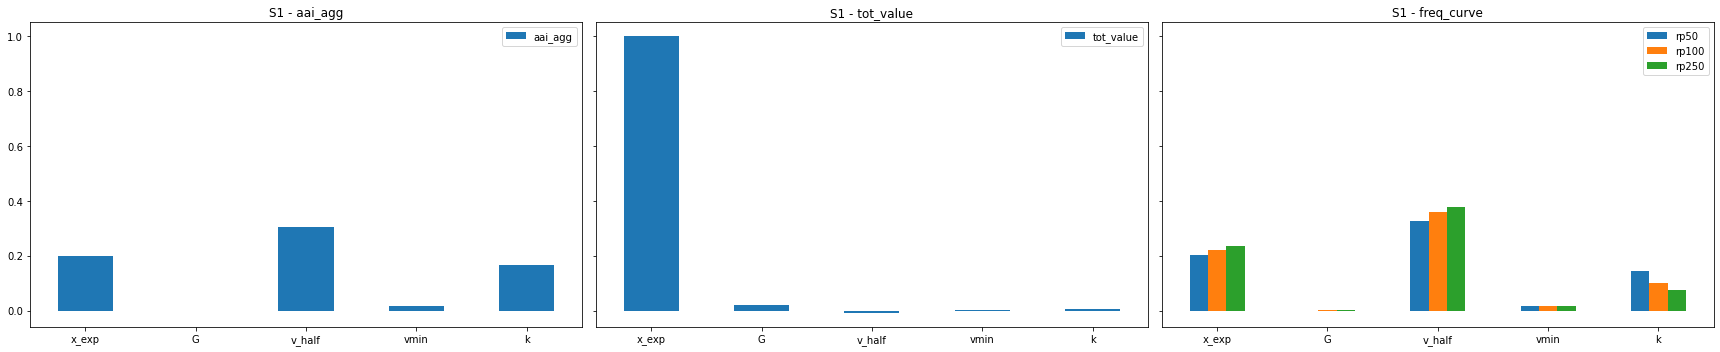

In [23]:
unc.plot_sensitivity();

Since we computed the distribution and sensitivity indices for the total impact at each exposure point, we can plot a map of the largest sensitivity index in each exposure location. This yields a rather suprising result that for every location, the most sensitive parameter is `x_exp`, the exposures scaling parameter.

array([<GeoAxesSubplot:title={'center':'Sensitivity map'}>], dtype=object)

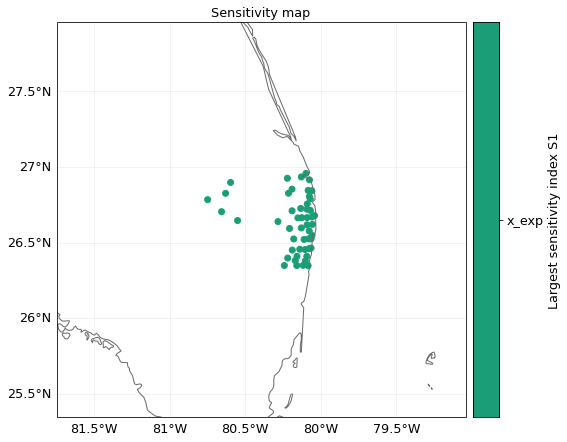

In [24]:
unc.plot_sensitivity_map(exp_base)

## UncCostBenefit

The uncertainty and sensitivity analysis for CostBenefit is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

Define the uncvar_func.

In [1]:
import copy
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.entity import Entity
from climada.hazard import Hazard

# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost):
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040  
    for meas in entity.measures.get_measure('TC'):
        meas.cost *= m_fut_cost
    return entity

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, haz=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


2021-06-22 15:47:36,920 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Check that costs for measures are changed as desired.

In [2]:
costs_1 = [meas.cost for meas in ent_fut_func(1).measures.get_measure('TC')]
costs_05 = [meas.cost for meas in ent_fut_func(0.5).measures.get_measure('TC')]
print(f"\nThe cost for m_fut_cost=1 are {costs_1}\n"
     f"The cost for m_fut_cost=0.5 are {costs_05}");


The cost for m_fut_cost=1 are [1311768360.8515418, 1728000000.0, 8878779433.630093, 9200000000.0]
The cost for m_fut_cost=0.5 are [655884180.4257709, 864000000.0, 4439389716.815046, 4600000000.0]


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Define the UncVars

In [3]:
import scipy as sp
from climada.engine.uncertainty import UncVar

haz_today = haz_base

haz_fut_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_fut_distr)

ent_today_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_today_unc = UncVar(ent_today_func, ent_today_distr)

ent_fut_distr = {"m_fut_cost":  sp.stats.norm(1, 0.1)}
ent_fut_unc = UncVar(ent_fut_func, ent_fut_distr)

Initialize the UncCostBenefit object and make a sample with N=10. Set `calc_second_order=False`.

In [4]:
from climada.engine.uncertainty import UncCostBenefit

unc = UncCostBenefit(haz_unc=haz_today, ent_unc=ent_today_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut_unc)
unc.make_sample(N=10, sampling_kwargs={'calc_second_order':False})

2021-06-22 15:47:37,791 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 50


,x_ent,x_haz_fut,m_fut_cost
0,0.919727,1.290039,1.004653
1,1.376758,1.290039,1.004653
2,0.919727,1.840820,1.004653
3,0.919727,1.290039,1.132387
4,1.376758,1.840820,1.132387
5,1.419727,2.790039,0.791544
6,0.876758,2.790039,0.791544
7,1.419727,3.340820,0.791544
8,1.419727,2.790039,0.976531
9,0.876758,3.340820,0.976531


For longer computations, it is possible to use a pool for parallel computation.

In [5]:
from pathos.pools import ProcessPool as Pool

pool = Pool()
unc.calc_distribution(pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-06-22 15:47:40,692 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:40,709 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:40,715 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:40,717 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:40,723 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:40,724 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:40,727 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:40,729 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:40,734 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:40,735 - climad

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization me

2021-06-22 15:47:41,289 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:41,321 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,329 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,336 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,337 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,343 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,347 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,349 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:41,353 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,357 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,360 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:41,365 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,369 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,376 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,380 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,385 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:41,385 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,385 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,387 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:41,389 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:41,395 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,398 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,401 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,402 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,408 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,409 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,412 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,409 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,414 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,417 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:41,418 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,421 - climada.engine.impact - INFO - Calc

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:41,450 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,449 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,452 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,453 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,455 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,441 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,459 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,459 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,458 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,459 - cli

2021-06-22 15:47:41,557 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,553 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,561 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,563 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,556 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:41,568 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,566 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,567 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,565 - climada.engine.impact - INFO - Calc

2021-06-22 15:47:41,659 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:41,638 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:41,660 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,656 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,666 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.

2021-06-22 15:47:41,669 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,672 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is

Building code             10.418            13.4214         1.28832021-06-22 15:47:41,762 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:41,764 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-06-22 15:47:41,768 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:41,768 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

--------------------  --------  --------
Total climate risk:   147.95    (USD bn)
Average annual risk:   17.0906  (USD bn)
Residual risk:         91.9219  (USD bn)
--------------------  --------  --------2021-06-22 15:47:41,771 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:41,772 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not 

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/s

2021-06-22 15:47:42,193 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:42,205 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,212 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:42,212 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,213 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,216 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,223 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,223 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,223 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,227 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,227 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,230 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,230 

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:42,270 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,273 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,275 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,278 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,279 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,282 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,284 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,283 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,286 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,286 - climada.e

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:42,308 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,309 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,308 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,312 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,317 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,313 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,320 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:42,325 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,321 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,321 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,327 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,331 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,332 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,332 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,340 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,337 - climada.engine.impact - INFO - 

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:42,369 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,367 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,370 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,371 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,372 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,373 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,376 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,377 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,378 - climada.engine.impact - INFO - Calc

2021-06-22 15:47:42,448 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:42,470 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,470 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31787          2.93592        2.22778
Beach nourishment          1.73604          2.37799        1.36978
Seawall                    8.92009          0.00282054     0.000316201
Building code              9.2428           1.78488        0.1931112021-06-22 15:47:42,468 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,473 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It'

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:42,560 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,564 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-06-22 15:47:42,565 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,568 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,571 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.03832           10.4022        10.0183
Beach nourishment          1.36779            8.21421        6.00547
Seawall       

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:42,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,602 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,606 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,607 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,606 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,607 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,611 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,612 - climada.engine.impact - INFO - Calculating damage for

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.28098             7.41416        5.78787
Beach nourishment          1.68745             5.81568        3.44644
Seawall                    8.67041             1.30529        0.150546
Building code              8.98409            43.1399         4.801822021-06-22 15:47:42,626 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,627 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-06-22 15:47:42,631 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,633 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.

2021-06-22 15:47:42,622 - climada.entity.exposures.base - IN

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)



2021-06-22 15:47:42,685 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,689 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
--------------------  --------  --------
Total climate risk:   77.3353   (USD bn)
Average annual risk:   8.85395  (USD bn)
Residual risk:        31.5788   (USD bn)
--------------------  --------  --------2021-06-22 15:47:42,693 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.

Net Present Values
2021-06-22 15:47:42,702 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,707 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:42,711 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,719 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:42,724 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:42,727 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,735 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:42,739 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:42,742 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:42,750 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.23081             7.6526         6.21754
Beach nourishment          1.62135             5.92005        3.65131
Seawall                    8.33079             1.85488        0.222653
Building code              8.63219            45.0948         5.22403

--------------------  --------  --------
Total climate risk:   180.379   (USD bn)
Average annual risk:   20.8872  (USD bn)
Residual risk:        119.857   (USD bn)
--------------------  --------  --------
Net Present Values


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3

2021-06-22 15:47:43,097 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,112 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,109 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,118 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,124 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,124 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,128 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,130 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,131 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,135 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,1

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,147 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,151 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,152 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,156 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,157 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,160 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,160 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,166 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,166 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,168 - climad

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,186 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,185 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,185 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,190 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,190 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,197 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,191 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,199 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,197 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,210 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,209 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,210 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,210 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,212 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,215 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:43,219 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,217 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,215 - climada.engine.impact - INF

2021-06-22 15:47:43,317 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:43,323 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,322 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,326 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:43,328 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,327 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,328 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,330 - climada.engine.impact - INFO - Calculating damage for

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,348 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,348 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:43,352 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,354 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:43,347 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:43,358 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,357 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to

2021-06-22 15:47:43,452 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,459 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,445 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
--------------------  --------  --------
Total climate risk:   118.602   (USD bn)
Average annual risk:   13.7089  (USD bn)
Residual risk:         64.1509  (USD bn)
--------------------  --------  --------2021-06-22 15:47:43,459 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,461 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,462 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,466 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It


2021-06-22 15:47:43,585 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
--------------------  -------  --------
Total climate risk:   192.5    (USD bn)
Average annual risk:   22.268  (USD bn)
Residual risk:        128.83   (USD bn)
--------------------  -------  --------

2021-06-22 15:47:43,590 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.23618             6.70078         5.42056
Beach nourishment          1.62843             5.27157         3.23722
Seawall                    8.36715             3.60281         0.43059
Building code              8.66986            48.1333          5.55182021-06-22 15:47:43,593 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's sugge

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/s

2021-06-22 15:47:43,915 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,927 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,934 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,938 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,947 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,951 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,958 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,962 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:43,970 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,975 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,982 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:43,983 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,987 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:43,993 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:43,995 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,002 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:44,005 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,007 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,009 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,014 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,017 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,016 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:44,019 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,022 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,026 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,028 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,031 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,029 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:44,032 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,034 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,038 - climada.engine.impact - 

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:44,066 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,067 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,072 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,072 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,072 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:44,071 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,078 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,079 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:44,079 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,082 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,086 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:44,088 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,087 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:44,089 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:44,092 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,094 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,094 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,094 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,098 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,102 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,101 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,105 - climada.engine.im

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,194 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,194 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,197 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,199 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,199 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,201 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,201 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,201 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:44,244 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,245 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,246 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,252 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,251 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,256 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:44,257 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,255 - climada.entity.exposures.base - INFO - Impact fun


2021-06-22 15:47:44,344 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-06-22 15:47:44,346 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,349 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
--------------------  ---------  --------
Total climate risk:    3.07351   (USD bn)
Average annual risk:   0.256394  (USD bn)
Residual risk:        -0.260358  (USD bn)
--------------------  ---------  --------
2021-06-22 15:47:44,352 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,356 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-06-22 15:47:44,357 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
M

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,362 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-06-22 15:47:44,365 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,366 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.


2021-06-22 15:47:44,375 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,376 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,378 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
--------------------  -------  --------
Total climate risk:   192.533  (USD bn)
Average annual risk:   22.268  (USD bn)
Residual risk:        128.825  (USD bn)
--------------------  -------  ---

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,396 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,400 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,408 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:44,408 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,409 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,411 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,414 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,415 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,415 - climada.entity.exposures

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,434 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,437 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,430 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,428 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.

2021-06-22 15:47:44,441 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,444 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  -----

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,506 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,511 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,514 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,522 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,527 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,530 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:44,538 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:44,543 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:44,547 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:44,555 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.27634          10.5363         8.25508
Beach nourishment          1.68133           8.57972        5.10293
Seawall                    8.63899           0.0192535      0.00222868
Building code              8.95154           7.63263        0.852661

--------------------  --------  --------
Total climate risk:   3

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3

2021-06-22 15:47:45,028 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:45,031 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:45,035 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:45,040 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:45,044 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:45,047 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,048 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,051 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,046 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,052 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:45,056 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,055 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,059 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:45,062 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:45,062 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,062 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,062 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,066 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,070 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,071 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,073 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,069 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,075 - climad

2021-06-22 15:47:45,166 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,171 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,173 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,174 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:45,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,176 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:45,178 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,180 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,176 - climada.engine.impact - INFO - 

2021-06-22 15:47:45,271 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:45,271 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,274 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:45,274 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,276 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,274 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,279 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf

2021-06-22 15:47:45,343 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,346 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,348 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:45,350 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:45,350 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-06-22 15:47:45,351 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:45,351 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:45,358 - climada.engine.cost_benefit - INFO - Computing cost b

--------------------  --------  --------
Total climate risk:   165.77    (USD bn)
Average annual risk:   19.2207  (USD bn)
Residual risk:        108.886   (USD bn)
--------------------  --------  --------2021-06-22 15:47:45,441 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.

Net Present Values
2021-06-22 15:47:45,449 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.32819            8.96663        6.75103
Beach nourishment          1.74963            7.03873        4.02299
Seawall                    8.98991            0.751479       0.0835913
Building code              9.31515           40.5839         4.35676

--------------------  --------  --------
Total climat

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/s

2021-06-22 15:47:46,171 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:46,183 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,193 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,198 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:46,206 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,209 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:46,212 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:46,215 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:46,218 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,222 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,222 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:46,224 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,227 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,229 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,230 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,233 - clima

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:46,239 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,240 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,239 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,240 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,243 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,243 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,248 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,248 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,250 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,250 - climada.en

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:46,262 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,262 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,262 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,264 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,265 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:46,267 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,268 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,273 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,274 - climada.engine.impact - INFO

2021-06-22 15:47:46,357 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,361 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,362 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,362 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,366 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,367 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,370 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:46,373 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,374 - climada.engine.impact - INFO - Expo

Building code              9.31515           40.5077         4.34858


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


2021-06-22 15:47:46,456 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,447 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,456 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-06-22 15:47:46,461 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,460 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:46,460 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,463 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
--------------------  --------  --------
Total climate risk:   162.031   (USD bn)
Average annual risk:   18.7434  (USD bn)
Residual risk:        105.044   (USD 

2021-06-22 15:47:46,540 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
Net Present Values2021-06-22 15:47:46,543 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-06-22 15:47:46,546 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-06-22 15:47:46,546 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,549 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:46,554 - climada.entity.exposures.base - INFO - Impact function column name 'if_TC' is not according to current naming conventions. It's suggested to use 'impf_TC' instead.
2021-06-22 15:47:46,556 - climada.engine.impact - INFO - Calculating damage for 50 a

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:46,905 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:46,912 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,917 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,920 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,925 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,927 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,931 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,933 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:46,939 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:46,941 - climad

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2021-06-22 15:47:47,219 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-06-22 15:47:47,227 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:47,231 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:47,234 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:47,238 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:47,241 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:47,244 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:47,247 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-22 15:47:47,251 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-22 15:47:47,254 - climad

The output of `CostBenefit.calc` is rather complex in its structure. The metrics dictionary inherits this complexity.

In [6]:
#Top level metrics keys
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

In [7]:
# The benefits and the cost_ben_ratio are available for each measuret
print(list(unc.metrics['benefit'].keys()))
print(list(unc.metrics['cost_ben_ratio'].keys()))

['Mangroves', 'Beach nourishment', 'Seawall', 'Building code']
['Mangroves', 'Beach nourishment', 'Seawall', 'Building code']


In [8]:
# The impact_meas_present and impact_meas_future provide values of the cost_meas, risk_transf, risk, 
# and cost_ins for each measure
print(list(unc.metrics['imp_meas_present'].keys()))
print(list(unc.metrics['imp_meas_future'].keys()))

['no measure-risk', 'no measure-risk_transf', 'no measure-cost_meas', 'no measure-cost_ins', 'Mangroves-risk', 'Mangroves-risk_transf', 'Mangroves-cost_meas', 'Mangroves-cost_ins', 'Beach nourishment-risk', 'Beach nourishment-risk_transf', 'Beach nourishment-cost_meas', 'Beach nourishment-cost_ins', 'Seawall-risk', 'Seawall-risk_transf', 'Seawall-cost_meas', 'Seawall-cost_ins', 'Building code-risk', 'Building code-risk_transf', 'Building code-cost_meas', 'Building code-cost_ins']
['no measure-risk', 'no measure-risk_transf', 'no measure-cost_meas', 'no measure-cost_ins', 'Mangroves-risk', 'Mangroves-risk_transf', 'Mangroves-cost_meas', 'Mangroves-cost_ins', 'Beach nourishment-risk', 'Beach nourishment-risk_transf', 'Beach nourishment-cost_meas', 'Beach nourishment-cost_ins', 'Seawall-risk', 'Seawall-risk_transf', 'Seawall-cost_meas', 'Seawall-cost_ins', 'Building code-risk', 'Building code-risk_transf', 'Building code-cost_meas', 'Building code-cost_ins']


We can plot the distributions for the top metrics or our choice.

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/

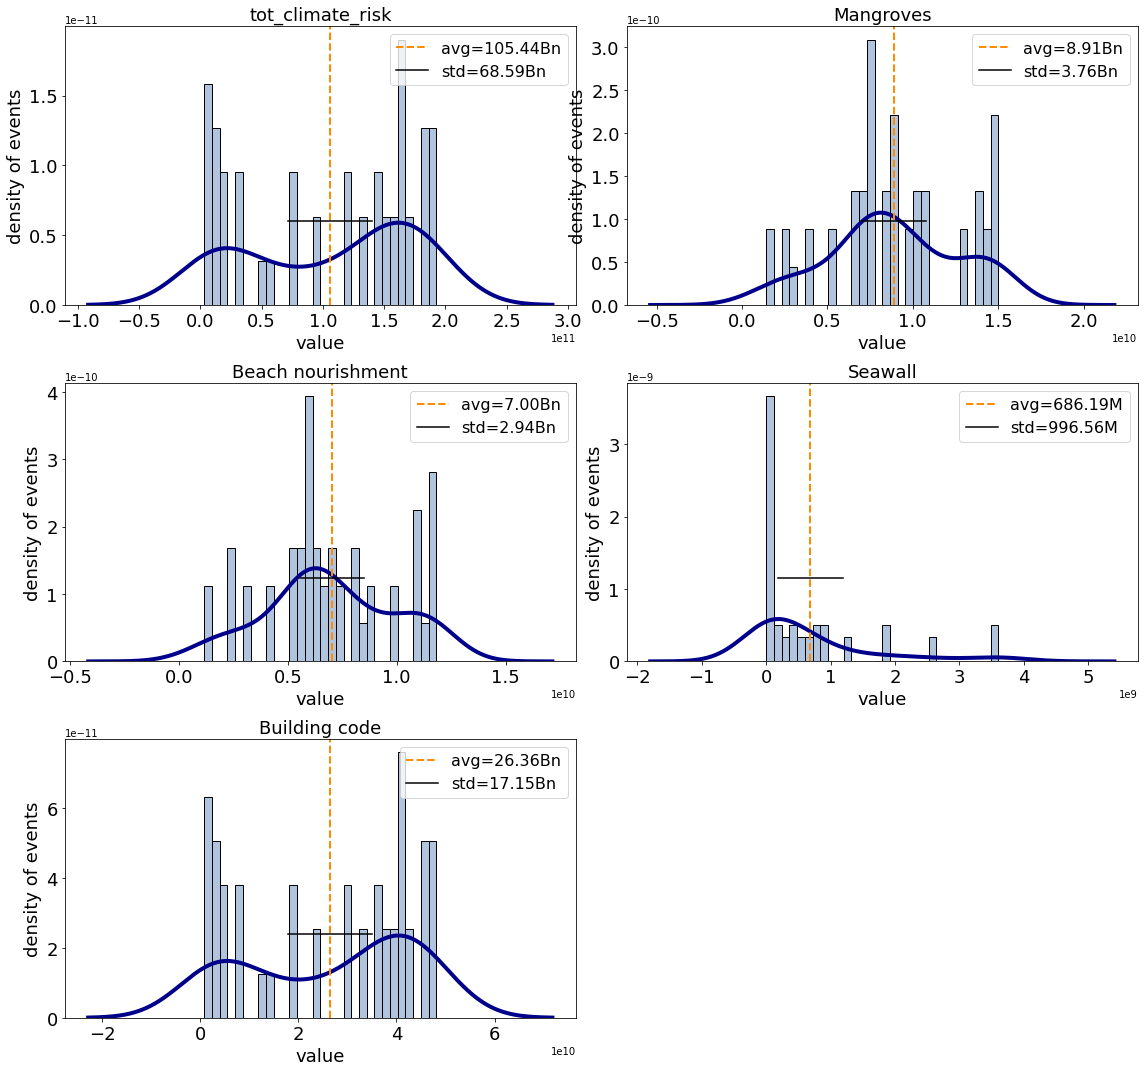

In [9]:
# tot_climate_risk and benefit
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/

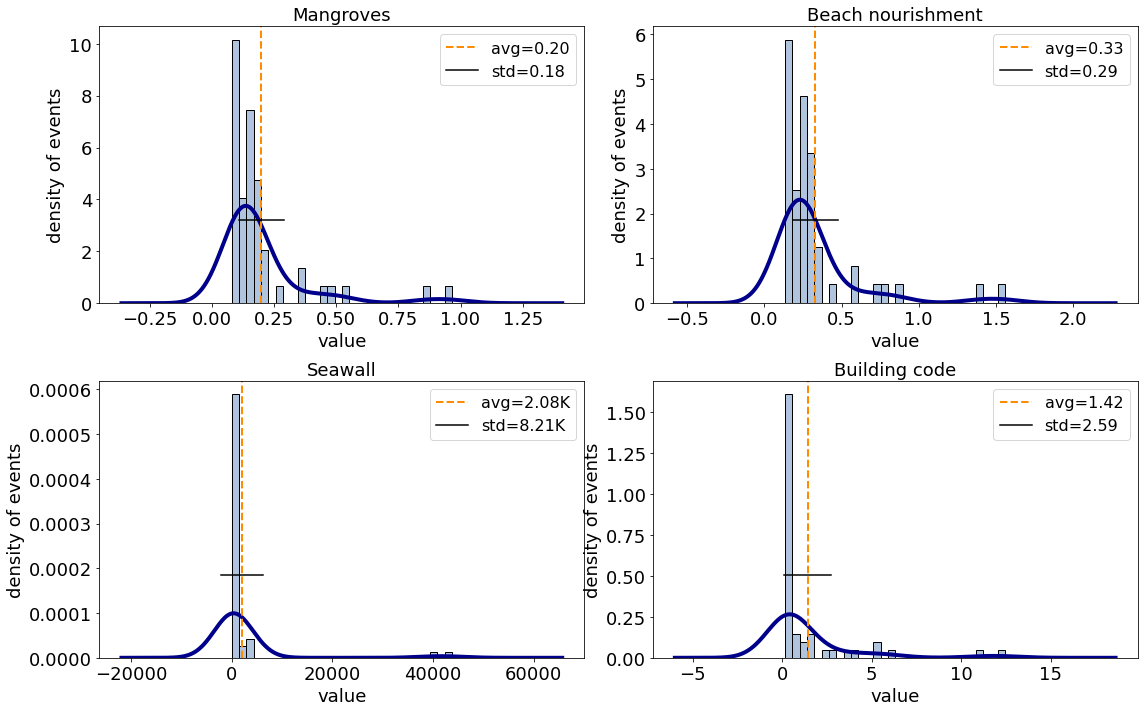

In [10]:
# cost benefit ratio
unc.plot_distribution(metric_list=['cost_ben_ratio'] );

Analogously to the impact example, now that we have a metric distribution, we can compute the sensitivity indices. Since we used the default sampling method, we can use the default sensitivity analysis method. However, since we used `calc_second_order = False` for the sampling, we need to specify the same for the sensitivity analysis.

In [11]:
unc.calc_sensitivity(method_kwargs = {'calc_second_order':False})

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/SALib/analyze/sobol.py:87: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/SALib/analyze/sobol.py:137: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/SALib/analyze/sobol.py:137: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/SALib/analyze/sobol.py:143: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/SALib/analyze/sobol.py:143: RuntimeWarning: i

{'tot_climate_risk': {'tot_climate_risk': {'S1': array([-0.00203406,  1.30805651,  0.        ]),
   'S1_conf': array([0.00210635, 0.83422163, 0.        ]),
   'ST': array([8.55006831e-06, 1.28467639e+00, 0.00000000e+00]),
   'ST_conf': array([4.87301672e-06, 5.69443630e-01, 0.00000000e+00])}},
 'benefit': {'Mangroves': {'S1': array([0.01508364, 1.4234898 , 0.        ]),
   'S1_conf': array([0.02149404, 0.74727614, 0.        ]),
   'ST': array([6.71986555e-04, 1.16378579e+00, 0.00000000e+00]),
   'ST_conf': array([0.00076537, 0.60817019, 0.        ])},
  'Beach nourishment': {'S1': array([0.01557013, 1.40197455, 0.        ]),
   'S1_conf': array([0.02107797, 0.76325519, 0.        ]),
   'ST': array([7.37074244e-04, 1.15982867e+00, 0.00000000e+00]),
   'ST_conf': array([0.00061251, 0.60417452, 0.        ])},
  'Seawall': {'S1': array([0.        , 0.84541059, 0.        ]),
   'S1_conf': array([0.        , 1.03378597, 0.        ]),
   'ST': array([0.       , 1.1560475, 0.       ]),
   'ST_

The sensitivity indices can be plotted. For the default method 'sobol', by default the 'S1' sensitivity index is plotted.

Note that since we have quite a few measures, the plot must be adjusted a bit or dropped. Also see that for many metrics, the sensitivity to certain uncertainty parameters appears to be 0. However, this result is to be treated with care. Indeed, we used for demonstration purposes a rather too low number of samples, which is indicated by large confidence intervals (vertical black lines) for most sensitivity indices. For a more robust result the analysis should be repeated with more samples.

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


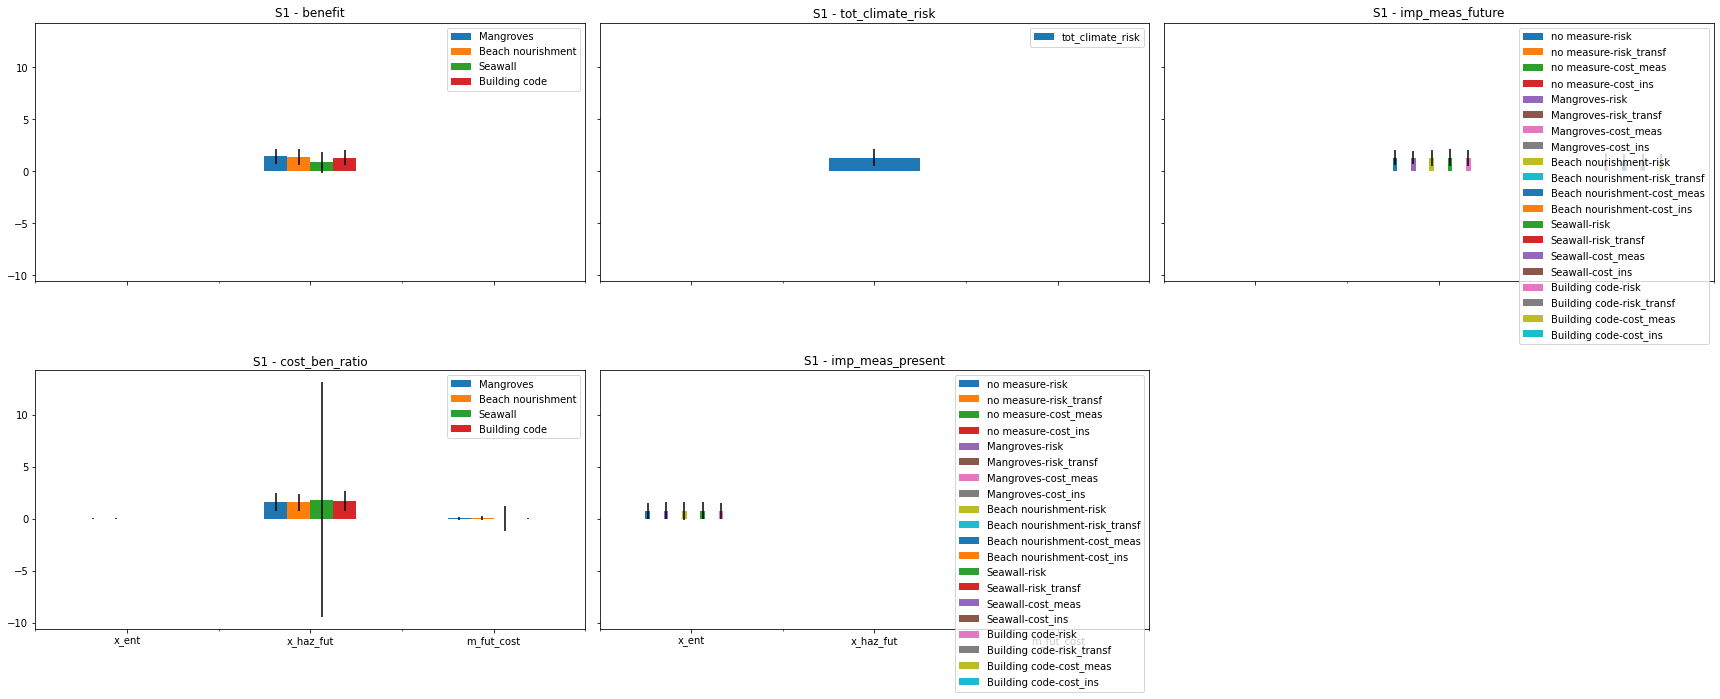

In [12]:
axes = unc.plot_sensitivity();

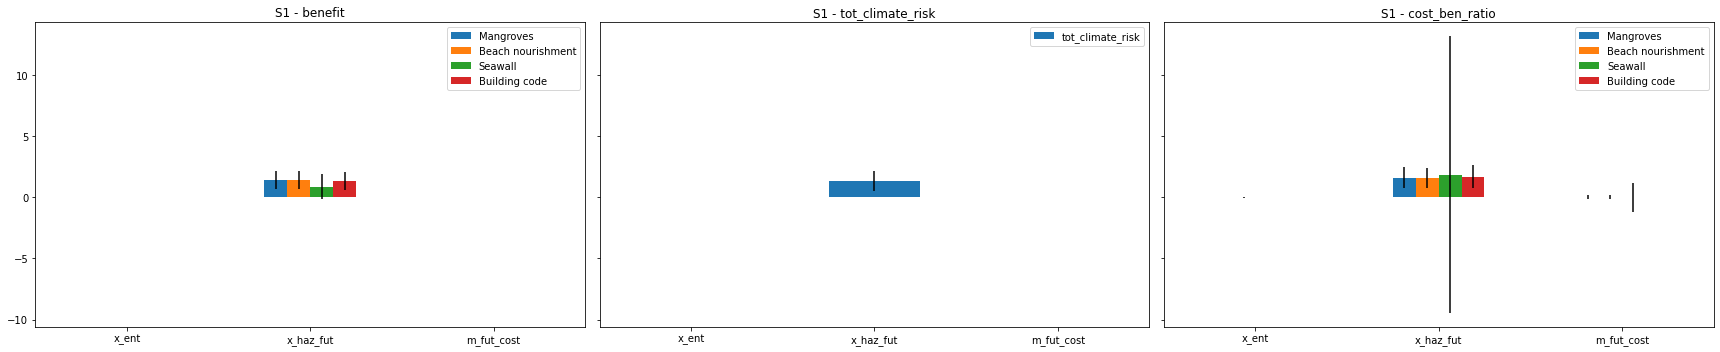

In [13]:
axes = unc.plot_sensitivity(metric_list=['cost_ben_ratio','tot_climate_risk','benefit']);